<div style="text-align: center;">
<h1 style="font-weight: bold; margin: 20px 0;">
LPS Training - Beginner Level: Illustrating Climate News Headlines with CCI Data 
</h1>
</div>


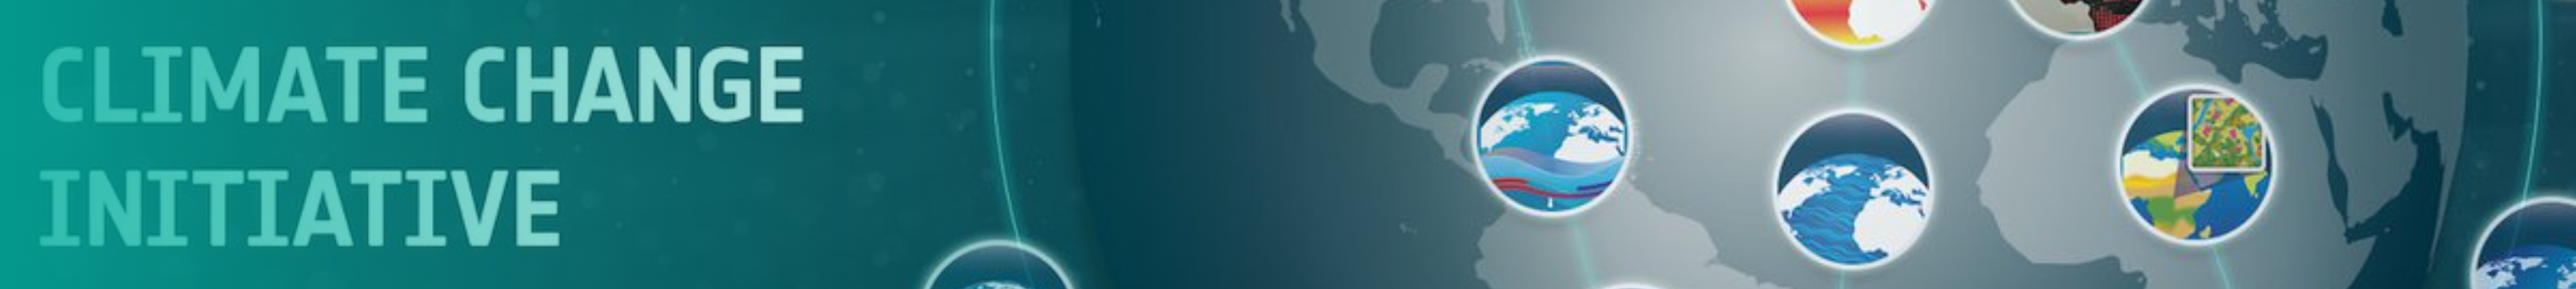

<div style="background-color: #e6f3ff;  padding: 10px; border-left: 5px solid #e6f3ff;">
<h2 style="margin: 0 0 15px 0; font-size: 1.4em;">1. Introduction:</h2>

In this beginner-friendly notebook, we will use real satellite-based data from the [ESA Climate Change Initiative (CCI)](https://climate.esa.int/en/odp/#/dashboard) to explore recent climate trends. The goal is to understand and **illustrate climate news headlines** using satellite-based measurements of essential climate variables.

We will use simple Python code and visualisations to explore questions such as:

* *Has global sea surface temperature an sea levels increased over the last decades?*
* *What did sea temperatures look like in record-warm years?*
* *What did LST and soil moisture conditions look like in record extreme fire events?*

This notebook is designed for **participants with no prior experience in Python or climate data analysis**. You will learn:

- How to access CCI climate data using the CCI Toolbox python Package
- How to navigate and subset climate data using Xarray
- How to create basic plots and statistics with Matplotlib
- How to save a figure you generated
- How to map and interpret ECVs changes over time and space
</div>

## Step 1. Setup & Imports

Before we can start working with the data, we need to import a few Python libraries. These libraries provide useful tools for working with satellite data, performing simple calculations, and creating visualizations.

Don’t worry if you’re not familiar with these yet — we’ll explain what you need as we go.

In [15]:
# ESA Climate Toolbox imports for accessing and plotting ESA CCI data
from esa_climate_toolbox.core import get_op              # Get predefined operations (e.g., time series, averages)
from esa_climate_toolbox.core import list_ecv_datasets   # List available datasets per ECV (Essential Climate Variable)
from esa_climate_toolbox.core import get_store           # Connect to an ESA data store
from esa_climate_toolbox.core import list_datasets       # List all datasets in a store
from esa_climate_toolbox.core import search
from esa_climate_toolbox.ops import plot                 # High-level plotting functions for CCI data

# Used for connecting to remote data sources (e.g., ESA CCI ODP)
from xcube.core.store import new_data_store

# For displaying geographic regions interactively (if desired)
from IPython.display import GeoJSON
import shapely.geometry   # Handling geometric objects like bounding boxes

# Core data science libraries
import pandas as pd       # For tabular data handling and time manipulation
import numpy as np        # For numerical operations
import xarray as xr       # For multi-dimensional climate data structures

# Mapping and plotting
import matplotlib.pyplot as plt       # Plotting library
import cartopy.crs as ccrs            # Cartographic projections for spatial data

# Notebook settings
import warnings
warnings.filterwarnings("ignore") # Suppressing warnings to keep notebook output clean
%matplotlib inline

**What we just did:**

* `numpy`: helps with numbers and arrays.
* `matplotlib`: lets us create plots and maps.
* `xarray`: makes it easy to work with climate datasets.
* `cartopy`: helps plot maps with geographic context.
* `Toolbox`: a package that facilitates access and computation of CCI data

Up next: We’ll learn how to **access ECVs** from the CCI Toolbox.

## Step 2: Load & Visualize Global SST
### Define the Dataset ID
To work with a specific ESA CCI dataset, we need to specify its **dataset ID**. This unique identifier tells the toolbox which variable and product we want to access.

In this section, we are using a the sea surface temperature (SST) zarr file. You can find the variables of the products under **data_vars**. For the SST, we will use the variable **analysed_sst**. 

First, we define the dataset ID and the store from which we retrieve the data (for the SST it is `esa-cci-zarr`). For this notebook we will focus on this dat With the command `describe_data`, we can have a look at the structure of the file, such as time, dimension and the variable stored within.

In [21]:
list_ecv_datasets("SST")

[('esacci.SST.climatology.L4.SSTdepth.multi-sensor.multi-platform.Climatology.2-2.r1',
  'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AATSR.Envisat.AATSR.2-1.day', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AATSR.Envisat.AATSR.2-1.night', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.ATSR-2.ERS-2.ATSR2.2-1.day', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.ATSR-2.ERS-2.ATSR2.2-1.night', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.ATSR.ERS-1.ATSR1.2-1.day', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.ATSR.ERS-1.ATSR1.2-1.night', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AVHRR-2.NOAA-11.AVHRR11_G.2-1.day', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AVHRR-2.NOAA-11.AVHRR11_G.2-1.night', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AVHRR-2.NOAA-12.AVHRR12_G.2-1.day', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AVHRR-2.NOAA-12.AVHRR12_G.2-1.night', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AVHRR-2.NOAA-14.AVHRR14_G.2-1.day', 'esa-cci'),
 ('esacci.SST.day.L3C.SSTskin.AVHRR-2.NOAA-14.AVHRR14_G.2-1.night', 'esa-cc

In [3]:
# Open the ESA CCI zarr store
cci_zarr_store = new_data_store("esa-cci-zarr")

In [13]:
# Which data do we have in the ESA CCI zarr store ?
list_datasets("esa-cci-zarr")

['ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-OCO-2-FOCAL-2014-2021-v10.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2020-fv2.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_DAY-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_NIGHT-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_DAY-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_NIGHT-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01de

In [4]:
data_id = 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr' 

### Describe Dataset (Check Available Variables and Metadata)

Before loading the full dataset, it’s helpful to **inspect the metadata** to understand its structure. This includes:

- Available variables (e.g., SST, uncertainty estimates)
- Temporal and spatial coverage
- Data format and structure

This step ensures we know what the dataset contains and how to work with it. It also helps confirm that the variable we want to plot or analyze is actually included.

🛠️ Tip: You can use the description to verify variable names, dimensions (e.g., `lat`, `lon`, `time`), and time coverage.

📘 More on dataset structure:  
🔗 [ESA Climate Toolbox – Data Access](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#accessing-data)

In [4]:
# Open the ESA CCI zarr store
cci_zarr_store.describe_data(data_id)

In [22]:
#open the sst dataset
sst_ds = cci_zarr_store.open_data(
    data_id=data_id)
display(sst_ds)

<xarray.Dataset> Size: 4TB
Dimensions:             (time: 12784, lat: 720, lon: 1440, fields: 16,
                         field_name_length: 50, fieldsp1: 17)
Coordinates:
  * field_name_length   (field_name_length) int32 200B 1 2 3 4 5 ... 47 48 49 50
  * fields              (fields) int32 64B 1 2 3 4 5 6 7 ... 11 12 13 14 15 16
  * fieldsp1            (fieldsp1) int32 68B 1 2 3 4 5 6 7 ... 12 13 14 15 16 17
  * lat                 (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 102kB 1982-01-01T12:00:00 ... 2...
Data variables:
    analysed_sst        (time, lat, lon) float64 106GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    analysis_number     (time, lat, lon) float64 106GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    anomaly_fields      (time, fields, lat, lon) float64 2TB dask.array<chunksize=(16, 16, 720, 720), meta=np.ndarray>
    field_name          (fields, field_name_length) |S1 800B dask.array<chunksize=(16, 50), meta=np.ndarray>
    gradient_fields     (time, fieldsp1, lat, lon) float64 2TB dask.array<chunksize=(16, 17, 720, 720), meta=np.ndarray>
    median_type         (time, lat, lon) float64 106GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    standard_deviation  (time, lat, lon) float64 106GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4
    acknowledgment:             Funded by ESA
    cdm_data_type:              grid
    comment:                    
    creator_email:              science.leader@esa-sst-cci.org
    creator_name:               SST_cci
    ...                         ...
    summary:                    An ensemble product with input from a number ...
    time_coverage_end:          20170101T000000Z
    time_coverage_start:        20161231T000000Z
    title:                      Global SST Ensemble, L4 GMPE
    uuid:                       dc0c5b25-93bf-4943-aba1-7f0de9109620
    westernmost_longitude:      -180.0

In [23]:
#Display SST variable
display(sst_ds.analysed_sst)

<xarray.DataArray 'analysed_sst' (time: 12784, lat: 720, lon: 1440)> Size: 106GB
dask.array<open_dataset-analysed_sst, shape=(12784, 720, 1440), dtype=float64, chunksize=(16, 720, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * time     (time) datetime64[ns] 102kB 1982-01-01T12:00:00 ... 2016-12-31T1...
Attributes:
    long_name:      median SST from GMPE
    source:         SST CCI V2, SST CCI V1.1, MyOcean, AVHRR_OI, CMC, HadISST...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      4500
    valid_min:      -300

### Calculate and plot the global mean of SST

To undertand how the SST has been changing during the last decades, we can calculate the mean across all latitudes and longitudes and plot a time series of the average SST over the world.

First let's have a look at the different operators from the Toolbox that we can use: 

In [24]:
from esa_climate_toolbox.core import list_operations
list_operations()

['add_dataset_values_to_geodataframe',
 'adjust_spatial_attrs',
 'adjust_temporal_attrs',
 'aggregate_statistics',
 'animate_map',
 'anomaly_external',
 'anomaly_internal',
 'arithmetics',
 'as_geodataframe',
 'climatology',
 'coregister',
 'data_frame_max',
 'data_frame_min',
 'data_frame_subset',
 'detect_outliers',
 'diff',
 'find_closest',
 'merge',
 'normalize',
 'plot',
 'plot_contour',
 'plot_hist',
 'plot_line',
 'plot_map',
 'plot_scatter',
 'query',
 'reduce',
 'resample',
 'select_features',
 'select_var',
 'statistics',
 'subset_spatial',
 'subset_temporal',
 'subset_temporal_index',
 'temporal_aggregation',
 'to_dataframe',
 'to_dataset',
 'tseries_mean',
 'tseries_point']

In [25]:
# Getting the time-series mean operator
ts_mean_op = get_op('tseries_mean')

In [26]:
# Apply the operation to our dataset , specifying the variable of interest
sst_global_mean = ts_mean_op(
    ds=sst_ds,
    var='analysed_sst'    
).compute()

In [6]:
# Show the yearly mean variable only:
sst_global_mean.analysed_sst_mean

<xarray.DataArray 'analysed_sst_mean' (time: 12784)> Size: 102kB
array([290.36496514, 290.38470105, 290.34813321, ..., 290.46784584,
       290.4821254 , 290.47114077], shape=(12784,))
Coordinates:
  * time     (time) datetime64[ns] 102kB 1982-01-01T12:00:00 ... 2016-12-31T1...
Attributes:
    long_name:                        median SST from GMPE
    source:                           SST CCI V2, SST CCI V1.1, MyOcean, AVHR...
    standard_name:                    sea_surface_foundation_temperature
    units:                            kelvin
    valid_max:                        4500
    valid_min:                        -300
    ESA_Climate_Toolbox_Description:  Mean aggregated over ['lat', 'lon'] at ...

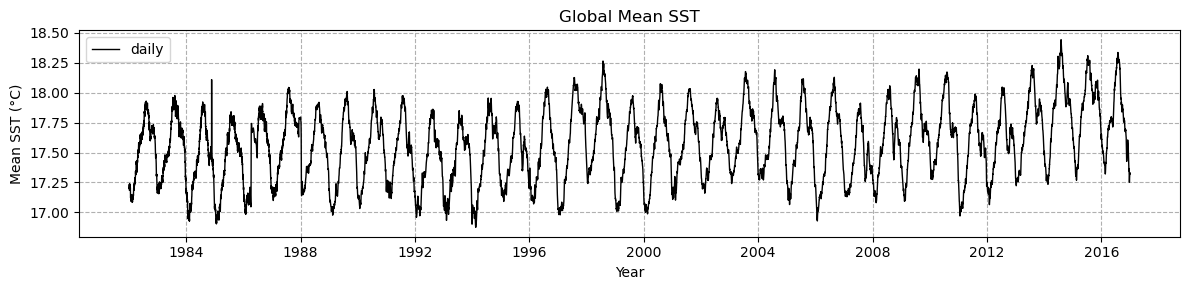

In [52]:
# Let's make our first plot of the computed yearly mean variable
# Plotting the global mean SST
fig = plt.figure(figsize=(12,3))
# Daily mean SST
(sst_global_mean.analysed_sst_mean-273.15).plot(c='k',linewidth=1,label='daily')
# Yearly mean SST
# Add the legend
plt.legend()
# Add a grid 
plt.grid(True, which='both',linestyle='--')
# Add a title and axis labels
plt.title('Global Mean SST')
plt.ylabel('Mean SST (°C)')
plt.xlabel('Year')
#how to save the figure
plt.savefig('Global-Mean-SST-1981-2016.png')
#plt.savefig('Global-Mean-SST-1981-2016.svg') 
plt.show()

In [30]:
#Now let's take a look at yearly mean SST , first we use the Toolbox again to compute the yearly mean:
resample_time = get_op('temporal_aggregation') #fetching the operator to temporally aggregate our data

sst_yearly_mean =resample_time(
    ds=sst_global_mean,
    method='mean',
    period='1YE'
) #note: it is also possible to use this operator for different periods, as well as computing maximum and minimum for a given period.


In [31]:
display(sst_yearly_mean.analysed_sst_mean)

<xarray.DataArray 'analysed_sst_mean' (time: 35)> Size: 280B
array([290.67865638, 290.71263459, 290.57345751, 290.5736195 ,
       290.65234775, 290.77306234, 290.68587203, 290.62347343,
       290.68756098, 290.66491099, 290.56368453, 290.56215117,
       290.61603171, 290.62830701, 290.66504478, 290.7525306 ,
       290.84920801, 290.65016895, 290.66946329, 290.74979866,
       290.70626204, 290.84315656, 290.78755742, 290.74356614,
       290.70635793, 290.60033397, 290.73383436, 290.82036263,
       290.84766798, 290.65539602, 290.72663577, 290.89399672,
       291.00827367, 291.01512291, 290.91388294])
Coordinates:
  * time     (time) datetime64[ns] 280B 1982-12-31 1983-12-31 ... 2016-12-31
Attributes:
    long_name:                        median SST from GMPE
    source:                           SST CCI V2, SST CCI V1.1, MyOcean, AVHR...
    standard_name:                    sea_surface_foundation_temperature
    units:                            kelvin
    valid_max:                        4500
    valid_min:                        -300
    ESA_Climate_Toolbox_Description:  Mean aggregated over ['lat', 'lon'] at ...

Text(0.5, 1.0, 'Time series of the yearly SST mean (1982-2016)')

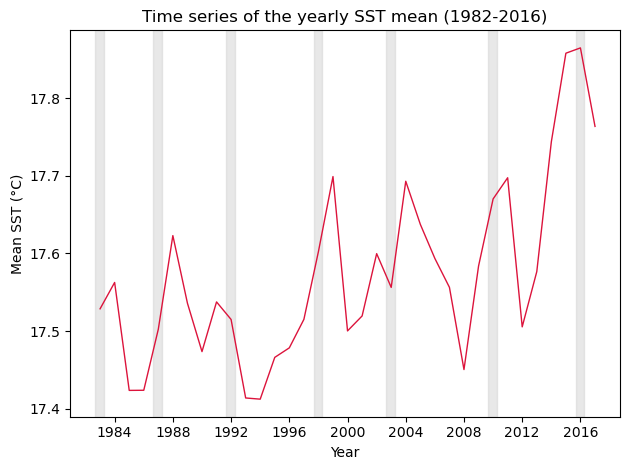

In [50]:
#Let's look at the change of yearly mean SST over the years, some years are much warmer than others:
(sst_yearly_mean.analysed_sst_mean-273.15).plot(c='crimson',linewidth=1,label='yearly')
# Define El Niño winters
elnino_periods = [
    (1982, 9, 1983, 3),
    (1986, 9, 1987, 3),
    (1991, 9, 1992, 3),
    (1997, 9, 1998, 3),
    (2002, 9, 2003, 3),
    (2009, 9, 2010, 3),
    (2015, 9, 2016, 3),
]
ax=plt.gca()
# Add grey shading for El Niño winters
for start_y, start_m, end_y, end_m in elnino_periods:
    start_date = pd.Timestamp(start_y, start_m, 1)
    end_date = pd.Timestamp(end_y, end_m, 1) + pd.offsets.MonthEnd(0)
    ax.axvspan(start_date, end_date, color='lightgrey', alpha=0.5)
plt.ylabel('Mean SST (°C)')
plt.xlabel('Year')
plt.title("Time series of the yearly SST mean (1982-2016)")

Text(0.5, 0, 'Year')

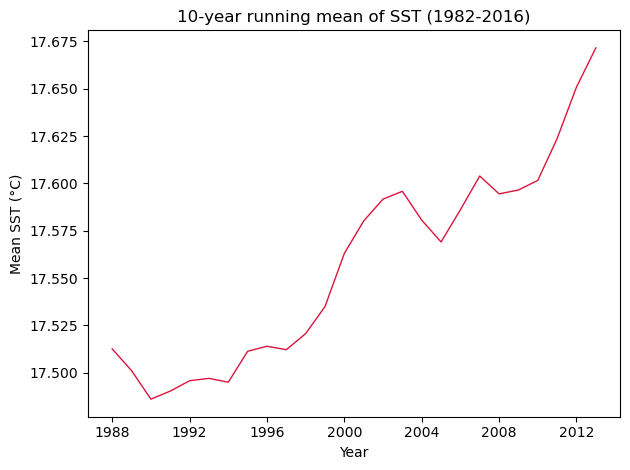

In [51]:
#In climate science  rolling means (f.i 10-year averages) are applied to suppress short-term internal variability: 
#SST is influenced by short-term noise like 
#ENSO (El Niño/La Niña, ~2–7-year cycles), 
#Volcanic eruptions that can cause temporary cooling (e.g., Pinatubo 1991) 
#Random ocean-atmosphere fluctuations.
#A 10-year rolling mean smooths out these high-frequency swings, revealing the underlying climate trend.
smooth_global_avg = sst_yearly_mean.analysed_sst_mean.rolling(time=10, center=True).mean()  
(smooth_global_avg-273.15).plot(c='crimson',linewidth=1)
plt.title("10-year running mean of SST (1982-2016)")
plt.ylabel('Mean SST (°C)')
plt.xlabel('Year')

In [33]:
#when was yearly mean SST the highest?
sst_yearly_mean.analysed_sst_mean.idxmax().dt.year

<xarray.DataArray 'year' ()> Size: 8B
array(2015)

In [39]:
#Let's plot our first spatial map: SST during the year 2015
#First we select only sst values for the year 2015:
#Temporal Subset
time_slice= '2015-01-01, 2015-12-31'
subset_temporal_op = get_op('subset_temporal')
SST_sub_2015 = subset_temporal_op(ds=sst_ds,time_range=time_slice)
display(SST_sub_2015)

<xarray.Dataset> Size: 112GB
Dimensions:             (time: 365, lat: 720, lon: 1440, fields: 16,
                         field_name_length: 50, fieldsp1: 17)
Coordinates:
  * field_name_length   (field_name_length) int32 200B 1 2 3 4 5 ... 47 48 49 50
  * fields              (fields) int32 64B 1 2 3 4 5 6 7 ... 11 12 13 14 15 16
  * fieldsp1            (fieldsp1) int32 68B 1 2 3 4 5 6 7 ... 12 13 14 15 16 17
  * lat                 (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 201...
Data variables:
    analysed_sst        (time, lat, lon) float64 3GB dask.array<chunksize=(11, 720, 720), meta=np.ndarray>
    analysis_number     (time, lat, lon) float64 3GB dask.array<chunksize=(11, 720, 720), meta=np.ndarray>
    anomaly_fields      (time, fields, lat, lon) float64 48GB dask.array<chunksize=(11, 16, 720, 720), meta=np.ndarray>
    field_name          (fields, field_name_length) |S1 800B dask.array<chunksize=(16, 50), meta=np.ndarray>
    gradient_fields     (time, fieldsp1, lat, lon) float64 51GB dask.array<chunksize=(11, 17, 720, 720), meta=np.ndarray>
    median_type         (time, lat, lon) float64 3GB dask.array<chunksize=(11, 720, 720), meta=np.ndarray>
    standard_deviation  (time, lat, lon) float64 3GB dask.array<chunksize=(11, 720, 720), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                CF-1.4
    acknowledgment:             Funded by ESA
    cdm_data_type:              grid
    comment:                    
    creator_email:              science.leader@esa-sst-cci.org
    creator_name:               SST_cci
    ...                         ...
    time_coverage_start:        2015-01-01T12:00:00
    title:                      Global SST Ensemble, L4 GMPE
    uuid:                       dc0c5b25-93bf-4943-aba1-7f0de9109620
    westernmost_longitude:      -180.0
    time_coverage_duration:     P365D
    time_coverage_resolution:   P1D

In [40]:
#Now we compute the mean over the year 2015
SST_sub_2015_avg=SST_sub_2015.analysed_sst.mean(dim='time')

In [41]:
SST_sub_2015_avg

<xarray.DataArray 'analysed_sst' (lat: 720, lon: 1440)> Size: 8MB
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float64, chunksize=(720, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [42]:
# Now let's plot our first spatial map: SST during the year 2015
# We need to load the two dimensions: latitute and longitude; and the variable
SST_15_plot= SST_sub_2015_avg.squeeze().load()
lat =SST_sub_2015_avg["lat"].values
lon = SST_sub_2015_avg["lon"].values

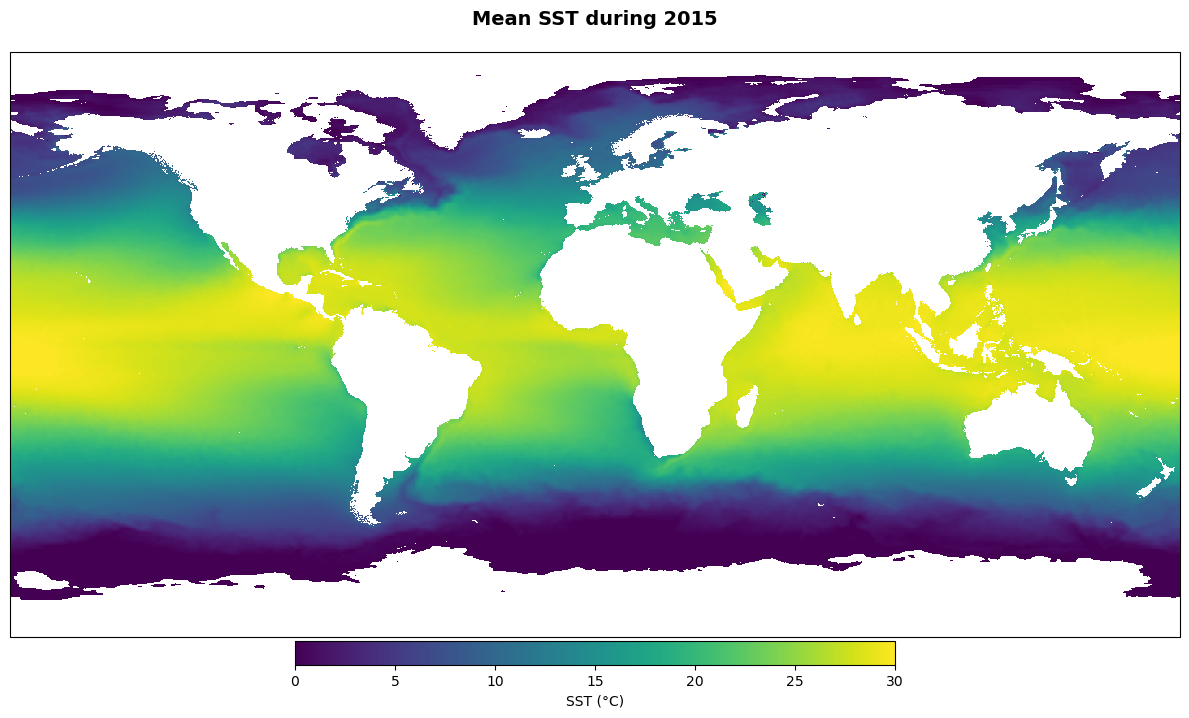

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = ax.pcolormesh( lon, lat, SST_15_plot - 273.15
      , vmin=0, vmax=30)
    
    
ax.set_title("Mean SST during 2015",
          fontsize=14, pad=20, weight='bold')

# Manually adding a colorbar below the plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label("SST (°C)")

plt.show()

- How abnormal was the SST during a very warm year ? Let's focus on a particularly hot year: 2015 coinciding with an El Nino event
- Let's take back the initial global dataset and compute the mean over the period 1981-2016: this will be our climatology.


In [46]:
#Computing the climatology over the period 1981-2016
# Compute yearly means first  
sst_yearly_means= sst_ds.resample(time='Y').mean('time')  
# Then average over all years  
sst_climato = sst_yearly_means.analysed_sst.mean('time') 
sst_climato

<xarray.DataArray 'analysed_sst' (lat: 720, lon: 1440)> Size: 8MB
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float64, chunksize=(720, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9

In [47]:
#PLotting the climatology
sst_climato_plot=sst_climato.squeeze().load()

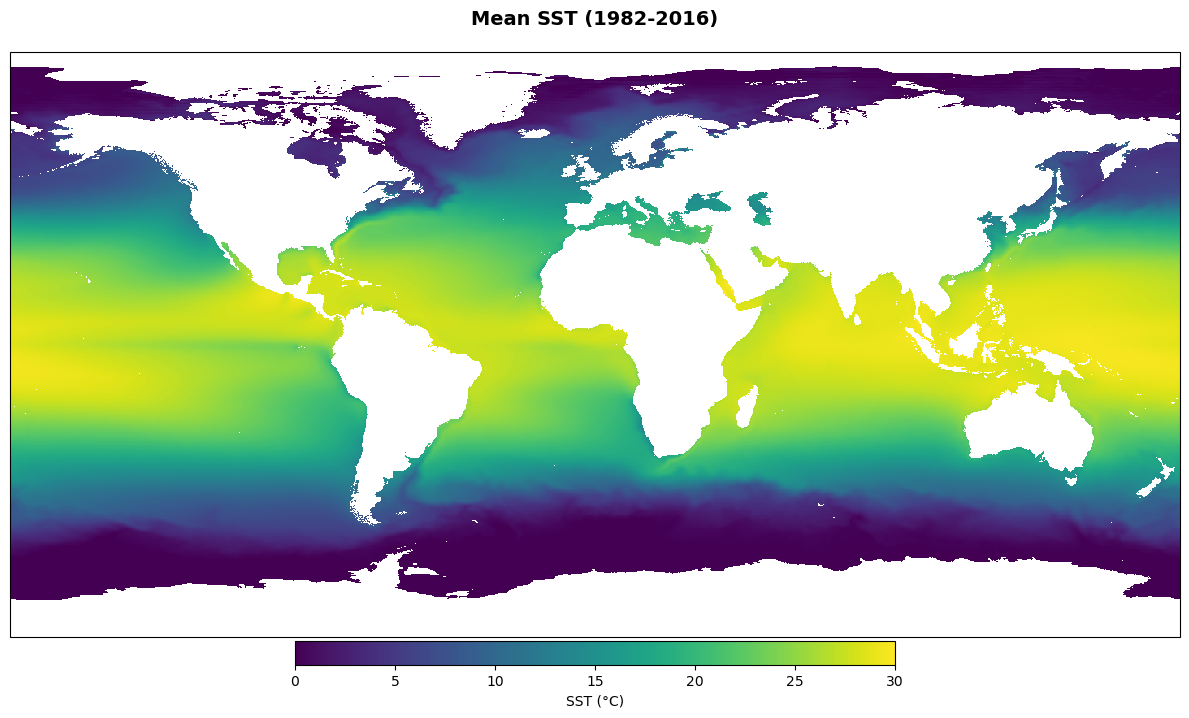

In [53]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = ax.pcolormesh( lon, lat, sst_climato_plot- 273.15
      , vmin=0, vmax=30)
    
    
ax.set_title("Mean SST (1982-2016)",
          fontsize=14, pad=20, weight='bold')

# Manually adding a colorbar below the plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label("SST (°C)")

plt.show()

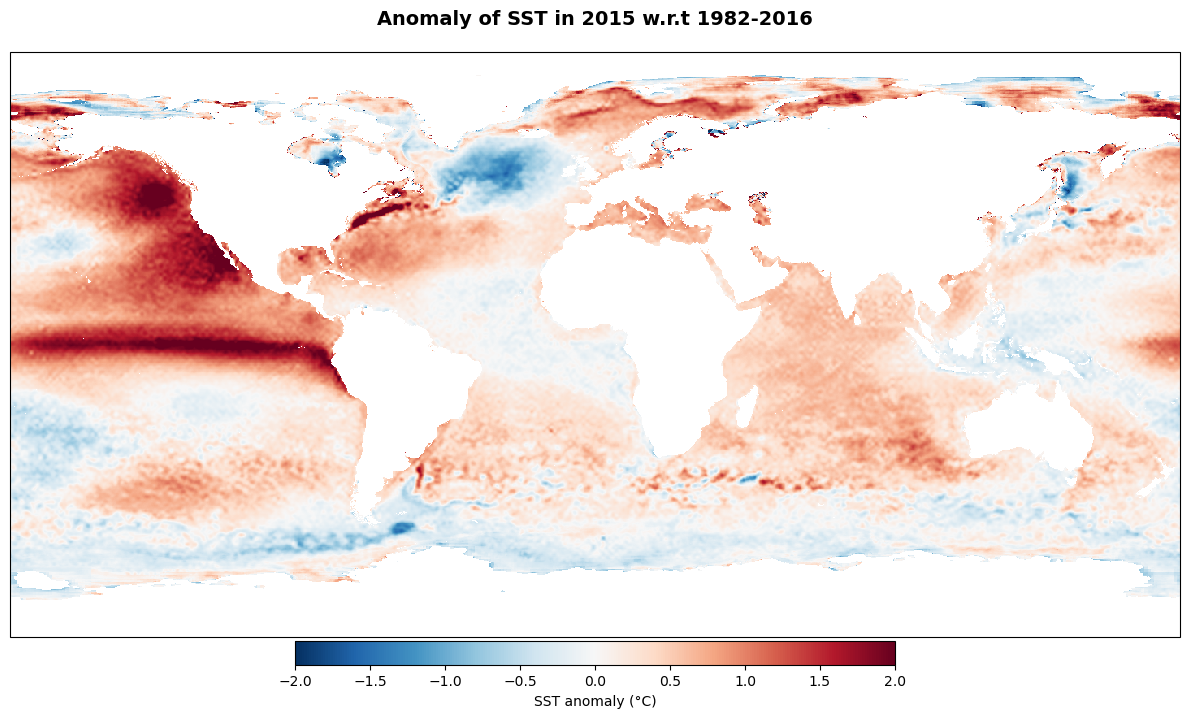

In [54]:
#PLotting the anomaly of SST in 2016 compared to 1981-2016
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = ax.pcolormesh( lon, lat, SST_15_plot - sst_climato_plot ,
      cmap='RdBu_r', vmin=-2, vmax=2)
    
    
ax.set_title("Anomaly of SST in 2015 w.r.t 1982-2016",
          fontsize=14, pad=20, weight='bold')

# Manually adding a colorbar below the plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label("SST anomaly (°C)")

plt.show()

### Your turn: Let's explore a few other examples with different ECVS

<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
👉 Your task: Below is the list of ECVs available in the ESA-CCI zarr datastore. Pick one of the three headlines below, and try to write a code to illustrate it, using the examples above.
    <div >

In [65]:
list_datasets("esa-cci-zarr")

['ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2020-fv4.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-OCO-2-FOCAL-2014-2021-v10.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2020-fv2.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_DAY-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3C-LST-MODISA-0.01deg_1DAILY_NIGHT-2002-2018-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_DAY-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1DAILY_NIGHT-1995-2020-fv3.00.zarr',
 'ESACCI-LST-L3S-LST-IRCDR_-0.01de

## Headline Example 1: "Global sea levels are rising as a result of human-caused global warming"

<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
👉 How would you illustrate this global increase based on previous examples?
    <div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
💡 Display the cheat codes cells for solutions
    
💡 For more information on the impacts of how climate change affects sea level rise, have a look at <a href="https://climate.esa.int/en/Scientific-highlights/Rising-seas/">this ESA-CCI Climate Story </a>
</div>

<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
👉 How would you illustrate this global increase based on previous examples?
</div>

In [ ]:
#Type your code here



In [92]:
#Cheat Code: opening the data
data_id = 'ESACCI-SEALEVEL-IND-MSLTR-MERGED-1993-2016-fv02.zarr'
variables = ['sla'] # we choose the sea level anomaly (sla)
sla_ds = cci_zarr_store.open_data(data_id)
display(sla_ds)

<xarray.Dataset> Size: 8MB
Dimensions:                (lat: 720, lon: 1440, time: 276)
Coordinates:
  * lat                    (lat) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * lon                    (lon) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * time                   (time) object 2kB 1993-01-15 00:00:00 ... 2015-12-...
Data variables:
    local_msl_trend        (lat, lon) float32 4MB dask.array<chunksize=(720, 720), meta=np.ndarray>
    local_msl_trend_error  (lat, lon) float32 4MB dask.array<chunksize=(720, 720), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.6
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/142052b9dc7...
    cdm_data_type:              Grid
    comment:                    These data were produced at CLS as part of th...
    contact:                    info-sealevel@esa-sealevel-cci.org
    creator_email:              info-sealevel@esa-sealevel-cci.org
    ...                         ...
    time_coverage_duration:     P23Y
    time_coverage_end:          2015-12-31 23:59:59
    time_coverage_resolution:   P1M
    time_coverage_start:        1993-01-01 00:00:00
    title:                      Mean Sea Level changes geographic distribution
    tracking_id:

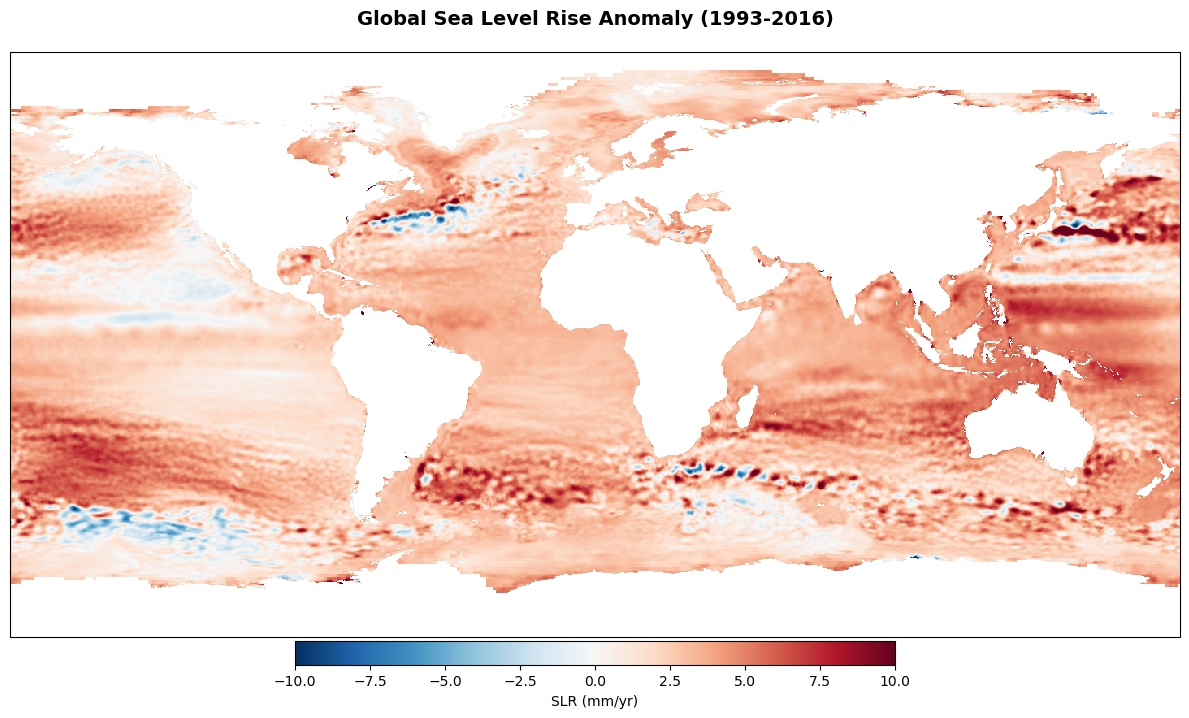

In [148]:
#Cheat Code: plotting the data
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
sla= sla_ds.local_msl_trend.squeeze().load()
lat = sla_ds["lat"].values
lon = sla_ds["lon"].values

mesh = ax.pcolormesh( lon, lat, sla,
        cmap="RdBu_r", vmin=-10, vmax=10,
    )
    
ax.set_title("Global Sea Level Rise Anomaly",
          fontsize=14, pad=20, weight='bold')

# Manually adding a colorbar below the plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label("SLR (mm/yr)")

plt.show()

## Headline Example 2: "Catastrophic wildfires hitting southeastern Australia in 2019-20 made worse due to climate change"

<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
👉 Which ESA-CCI climate variables from the .zarr datastore would use to look at the conditions that made the wildfires in Australia in 2019-2020 so severe ? 

👉How would you plot spatial maps of these conditions during this period ? How would you compare them to average conditions?
</div>

In [ ]:
#Type your code here




<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
💡 Display the cheat codes cells for solutions
    
💡 For more information on this extreme event, have a look at <a href="https://www.bbc.com/news/science-environment-51742646">this BBC News article </a> and 
<a href="https://earth.esa.int/eogateway/gallery/wildfires-in-australia-2019">this ESA article  </a>. Note that ESA-CCI has developped a Bruned Area product, not yet available on the CCI .zarra datastore of the Toolbox but you can find out more <a href="https://climate.esa.int/en/projects/fire/">here </a>.
</div>

In [22]:
# Focus on South-Eastern Australia (bbox: 140, -45, 155, -25) during 2019 heatwave
bbox = (140, -45, 155, -25)  
# Display bounding box for reference
GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

In [7]:
#We suggest to use the following monthly LST data
data_id = 'ESACCI-LST-L3S-LST-IRCDR_-0.01deg_1MONTHLY_DAY-1995-2020-fv3.00.zarr'
LST_ds = cci_zarr_store.open_data(data_id)
LST_ds 

<xarray.Dataset> Size: 18TB
Dimensions:          (channel: 2, time: 294, lat: 18000, lon: 36000,
                      length_scale: 294)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 72kB -90.0 -89.99 -89.98 ... 89.98 89.99
  * lon              (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time             (time) datetime64[ns] 2kB 1995-08-01 ... 2020-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lcc              (time, lat, lon) float32 762GB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst              (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    n                (time, lat, lon) float32 762GB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    sataz            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    satze            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    solaz            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
    solze            (time, lat, lon) float64 2TB dask.array<chunksize=(1, 2250, 2250), meta=np.ndarray>
Attributes: (12/42)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    summary:                    This file contains level L3S global land surf...
    time_coverage_duration:     P1M
    time_coverage_end:          19700101T000001Z
    time_coverage_resolution:   P1M
    time_coverage_start:        19700101T000001Z
    title:                      ESA LST CCI land surface temperature time ser...

In [8]:
#Cheat code for regional selection
subset_spatial_op = get_op('subset_spatial')
LST_sub = subset_spatial_op(ds=LST_ds, region=bbox)
#display spatial subset
LST_sub

In [10]:
#Cheat code for Temporal Subset
time_slice= '2019-01-01, 2019-12-31'
subset_temporal_op = get_op('subset_temporal')
LST_sub_2019 = subset_temporal_op(ds=LST_sub,time_range=time_slice)
LST_sub_2019

<xarray.Dataset> Size: 3GB
Dimensions:          (channel: 2, time: 12, lat: 2002, lon: 1502,
                      length_scale: 294)
Coordinates:
  * channel          (channel) float64 16B 11.0 12.0
  * lat              (lat) float32 8kB -45.01 -44.99 -44.99 ... -25.01 -25.0
  * lon              (lon) float32 6kB 140.0 140.0 140.0 ... 155.0 155.0 155.0
  * time             (time) datetime64[ns] 96B 2019-01-01 ... 2019-12-01
Dimensions without coordinates: length_scale
Data variables: (12/14)
    dtime            (time, lat, lon) timedelta64[ns] 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    lcc              (time, lat, lon) float32 144MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    lst              (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    lst_unc_loc_atm  (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    lst_unc_loc_cor  (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    lst_unc_loc_sfc  (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    ...               ...
    lst_uncertainty  (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    n                (time, lat, lon) float32 144MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    sataz            (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    satze            (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    solaz            (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
    solze            (time, lat, lon) float64 289MB dask.array<chunksize=(1, 1, 1502), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                CF-1.8
    catalogue_url:              https://catalogue.ceda.ac.uk/uuid/6babb8d9a8d...
    cdm_data_type:              grid
    comment:                    These data were produced as part of the ESA L...
    creator_email:              djg20@le.ac.uk
    creator_name:               University of Leicester Surface Temperature G...
    ...                         ...
    time_coverage_end:          2019-12-01T00:00:00
    time_coverage_resolution:   P1M
    time_coverage_start:        2019-01-01T00:00:00
    title:                      ESA LST CCI land surface temperature time ser...
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((139.989990234375 -45.01000213623047,...

In [53]:
#Let's take only the month of December 2019:
LST_sub_2019_Dec=LST_sub.lst.time.sel(time='2019-12')

In [17]:
#Cheat Code: loading values for plotting
lat = LST_sub_2019["lat"].values
lon = LST_sub_2019["lon"].values
LST_sub_2019_Dec=LST_sub_2019_Dec.squeeze().load()
LST_sub_2019_Dec

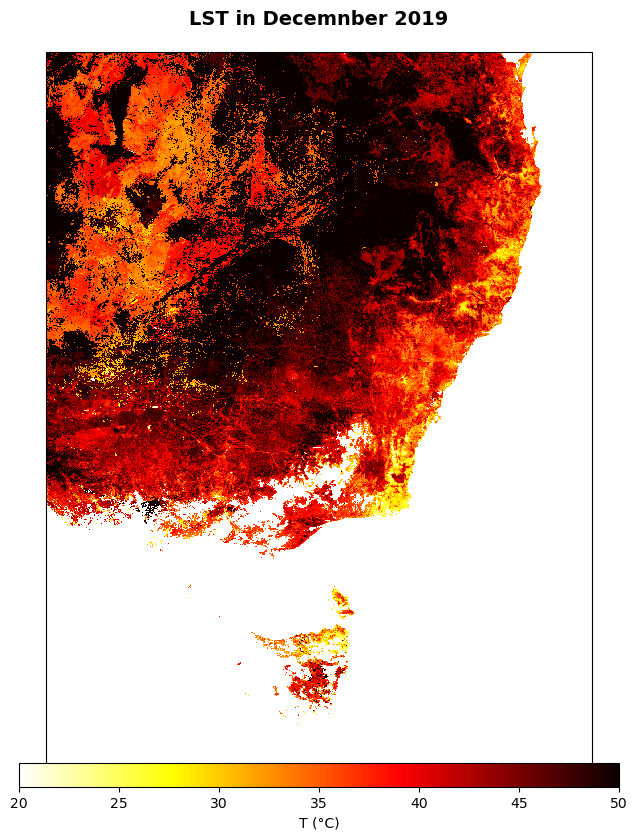

In [24]:
#Cheat Code: Plotting the spatial map on December 2019 (time of peak conditions of the observed extreme event)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

mesh = ax.pcolormesh( lon, lat, LST_sub_2019_Dec - 273.15,
        cmap="hot_r", vmin=20, vmax=50
    )
    #you can adjust vmin and vmax values
ax.set_title("LST in Decemnber 2019",
          fontsize=14, pad=20, weight='bold')

# Manually adding a colorbar below the plots
cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.03])   # you can adjust the colorbar position: [left, bottom, width, height]
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cbar.set_label("T (°C)")

plt.show()

In [ ]:
#Let's take all december months from 1995 to 2019
LST_climato_Dec=LST_sub.lst.time.sel(time=LST_sub.lst['time'].dt.month == 12)

In [47]:
# Cheat Code: How abnormal was this event ? - Computation of Climatology
#Let's take all December months from 1995 to 2019
#ow let's compare December 2019 with the climatology of monthly mean temperature over the period 1995-2019
#Cheat Code: loading values for plotting
LST_climato_Dec=LST_sub.lst.sel(time=LST_sub['time'].dt.month == 12).mean(dim='time')  
LST_climato_Dec=LST_climato_Dec.squeeze().load()

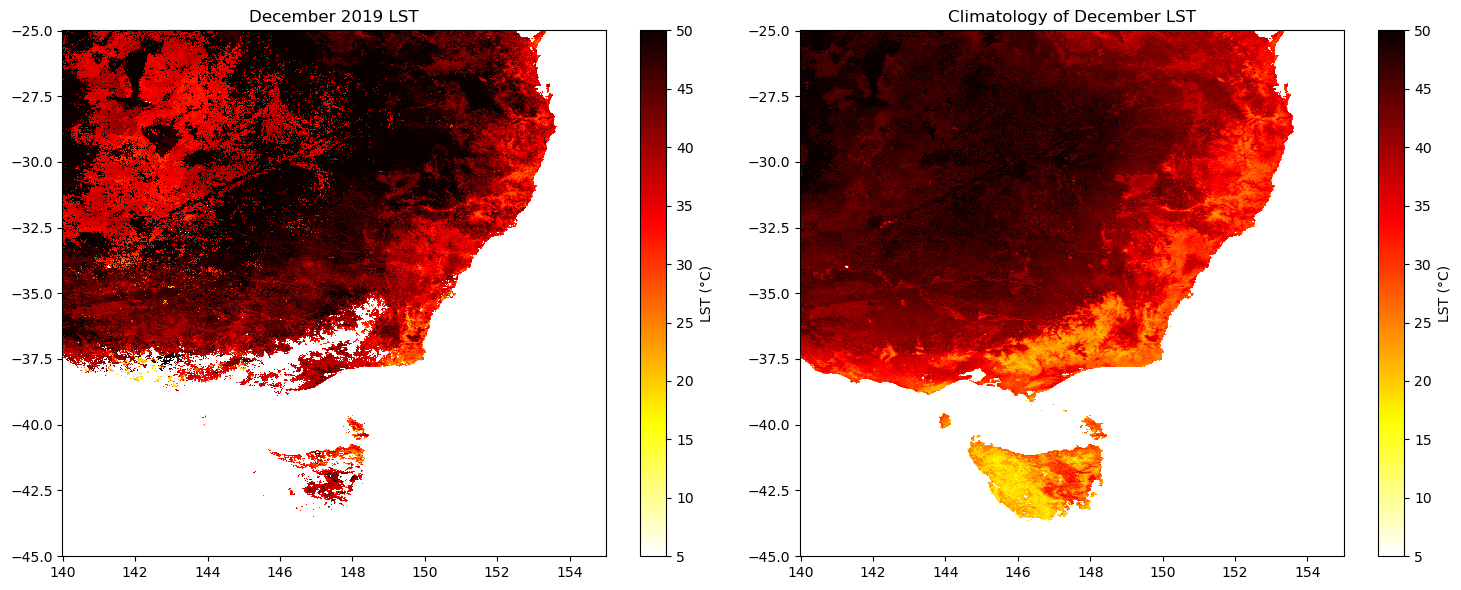

In [52]:
# Cheat Code: How abnormal was this event ? -  Plots
# PLot the map for the December climatology and for December 2019 side by side

# Plot side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot max daytime LST (left)
im1 = ax1.pcolormesh( lon, lat,LST_sub_2019_Dec-273.15, cmap='hot_r', vmin=5, vmax=50)
ax1.set_title('December 2019 LST')
plt.colorbar(im1, ax=ax1, label='LST (°C)')

# Plot December climatology
im2 = ax2.pcolormesh( lon, lat,LST_climato_Dec - 273.15, cmap='hot_r', vmin=5, vmax=50)
ax2.set_title('Climatology of December LST')
plt.colorbar(im2, ax=ax2, label='LST (°C)')
plt.tight_layout()
plt.show()


<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px;">
👉Bonus Question: Now compute the anomaly of December LST in 2019 with respect to 1995-2020
    </div>

In [96]:
#You can do the same for soil moisture now - Cheat Code to open the data 
#!This data is daily and not monthly -
data_id = 'ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr'
#cci_zarr_store.describe_data(data_id)
SM_ds = cci_zarr_store.open_data(data_id)
SM_ds

<xarray.Dataset> Size: 575GB
Dimensions:         (time: 15402, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time            (time) datetime64[ns] 123kB 1978-11-01 ... 2020-12-31
Data variables:
    dnflag          (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    flag            (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    freqbandID      (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    mode            (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sensor          (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm              (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 64GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    t0              (time, lat, lon) datetime64[ns] 128GB dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    This dataset was produced with funding of the...
    contact:                    cci_sm_contact@eodc.eu
    creator_email:              cci_sm_contact@eodc.eu
    creator_name:               Department of Geodesy and Geoinformation, Tec...
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_end:          2020-12-31 00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1978-11-01 00:00:00
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    tracking_id:                174f51a4-6a06-4352-a712-4d3f77bd8166

In [57]:
#Type your code here:




In [85]:
#Type your code here:





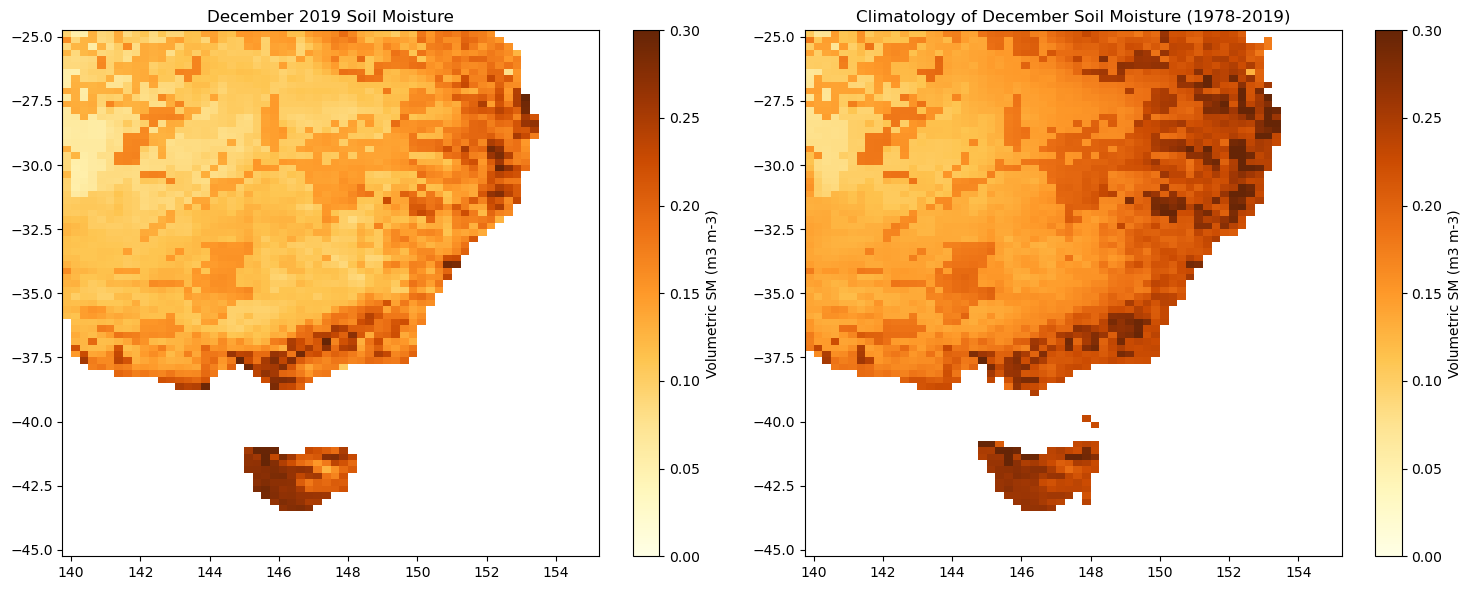

In [91]:
# Example of Plots: How abnormal was this event ?